# Question 1

Original code

[[ 9.63091486e-01  2.77230199e-02 -6.86159131e+02]
 [-2.77230199e-02  9.63091486e-01  6.90176067e+01]]
[[ 1.15464782e+00 -1.30983988e-02 -8.31059947e+02]
 [ 5.75871665e-02  1.09998765e+00 -8.46865727e+01]
 [ 7.91412660e-05 -1.69150607e-06  1.00000000e+00]]
-853 -85 2016 1583


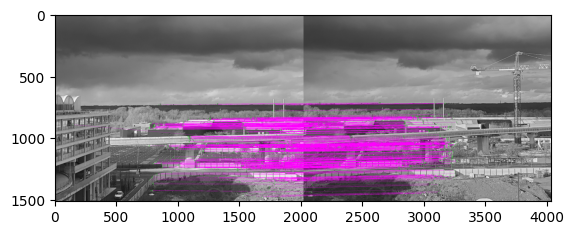

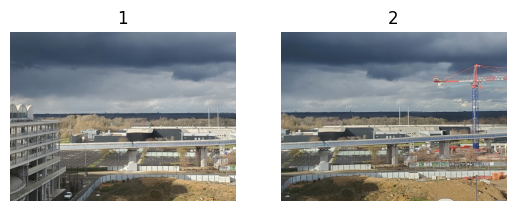

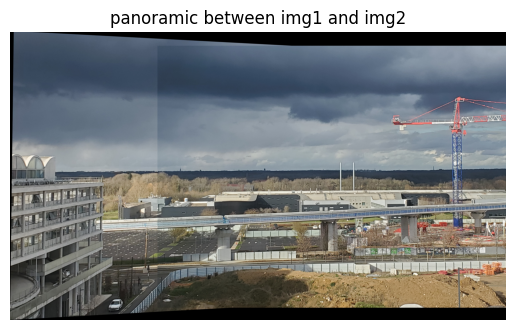

True

In [14]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  2 13:49:38 2022

@author: roux
"""


import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow, show, subplot, title, axis, figure


# draw matches
def draw_matches(img1, kpt1, img2, kpt2, matches):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Create a blank image with the size of the first image + second image
    new_img = np.zeros((max([h1, h2]), w1 + w2, 3), dtype='uint8')
    new_img[:h1, :w1, :] = np.dstack([img1, img1, img1])
    new_img[:h2, w1:w1 + w2, :] = np.dstack([img2, img2, img2])

    # extract the match keypoints
    for m in matches:
        (x1, y1) = kpt1[m.queryIdx].pt
        (x2, y2) = kpt2[m.trainIdx].pt

        # Draw circles on the keypoints
        cv.circle(new_img, (int(x1), int(y1)), 4, (0, 255, 0), 1)
        cv.circle(new_img, (int(x2) + w1, int(y2)), 4, (0, 255, 0), 1)

        # Connect the same keypoints
        cv.line(new_img, (int(x1), int(y1)), (int(x2) + w1, int(y2)), (255, 0, 255), 1)

    return new_img


def warpImages(img1, img2, M):
    # get the corner coordinates of the "query" and "train" image
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    pts_corners_src = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts_corners_temp = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)

    # When we have established a homography we need to warp perspective
    # perform perspective tranform using previously calculated matrix and the corners of  
    #"query" image#
    # Change field of view
    pts_corners_dst = cv.perspectiveTransform(pts_corners_temp, M)

    ListOfPoints = np.concatenate((pts_corners_src, pts_corners_dst), axis=0)

    [x_min, y_min] = np.int32(ListOfPoints.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(ListOfPoints.max(axis=0).ravel() + 0.5)

    print(x_min,y_min,x_max,y_max)

    translation_dist = [-x_min, -y_min]

    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 
1]])

    new_img = cv.warpPerspective(img2, H_translation.dot(M), (x_max - x_min, y_max - y_min))
    new_img[translation_dist[1]:h1 + translation_dist[1], translation_dist[0]:w1 + translation_dist[0]] = img1

    return new_img



def find_homography(kpt1, kpt2, matches):
    # Find an Homography matrix between two pictures
    # Transforming keypoints to list of points
    src_pts = np.float32([kpt1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kpt2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Compute a rigid transformation (without depth, only scale + rotation + translation) /affine transformation
    transformation_rigid_matrix, mask = cv.estimateAffinePartial2D(src_pts, dst_pts)
    # transformation_rigid_matrix, mask = cv.estimateAffinePartial2D(src_pts, dst_pts)

    print(transformation_rigid_matrix)
    
    affine_row = [0, 0, 1]
    M= np.vstack((transformation_rigid_matrix, affine_row))
        
    M, mask = cv.findHomography(src_pts, dst_pts,cv.RANSAC,3)
    matchesMask = mask.ravel().tolist()
    print(M)
    
    #return transformation_rigid_matrix,matchesMask

    return M


outputName='panorama.tif'





img1c = cv.imread('palaiseau-B1sub.tif',1)
img2c = cv.imread('palaiseau-B2sub.tif',1)
#
#img2c = cv.imread('panorama.tif',1)
#img1c = cv.imread('palaiseau-B3sub.tif', 1)

img1 = cv.cvtColor(img1c, cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(img2c, cv.COLOR_BGR2GRAY)

img1c = cv.cvtColor(img1c, cv.COLOR_BGR2RGB)
img2c = cv.cvtColor(img2c, cv.COLOR_BGR2RGB)

# Initiate ORB detector, that it will be our detector object.
orb = cv.ORB_create(10000)


# find the keypoints and compute the descriptors with ORB for images
kpts1, des1 = orb.detectAndCompute(img1, None)
kpts2, des2 = orb.detectAndCompute(img2, None)


# Create a BFMatcher object.
bf = cv.BFMatcher_create(cv.NORM_HAMMING)

# match descriptor
matches1to2 = bf.knnMatch(des1, des2, k=2)


# draw matches
good1to2 = []
for m, n in matches1to2:
    if m.distance < 0.6 * n.distance:
        good1to2.append(m)

drawimg=draw_matches(img1, kpts1, img2, kpts2, good1to2)


# find  affine transformation and panoramic view between 1 to 2
matrix1to2 = find_homography(kpts1, kpts2, good1to2)
img1to2 = warpImages(img2c, img1c, matrix1to2)

figure()

imshow(drawimg)
show()


figure()

subplot(1, 2, 1)
imshow(img1c)
axis('off')
title('1')

subplot(1, 2, 2)
imshow(img2c)
axis('off')
title('2')

show()

figure()

title1 = "panoramic between img1 and img2"

subplot(1, 1, 1)
imshow(img1to2)
axis('off')
title(title1)

show()

img1to2 = cv.cvtColor(img1to2, cv.COLOR_BGR2RGB)
cv.imwrite(outputName,img1to2)

Changing kind of features

[[ 9.57768518e-01 -1.20717942e-02 -6.32369056e+02]
 [ 1.20717942e-02  9.57768518e-01 -7.60867798e-01]]
[[ 1.12610224e+00 -1.81582350e-02 -7.98937462e+02]
 [ 4.95748438e-02  1.07521558e+00 -6.72601831e+01]
 [ 6.93615182e-05 -6.43376583e-06  1.00000000e+00]]
-835 -67 2016 1574


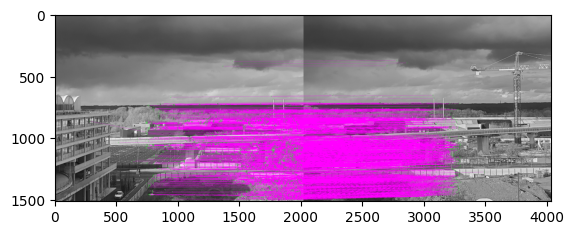

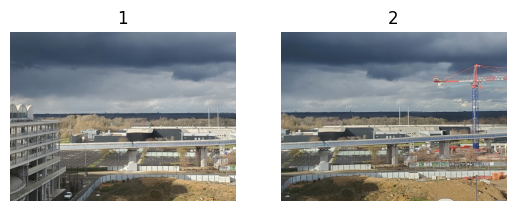

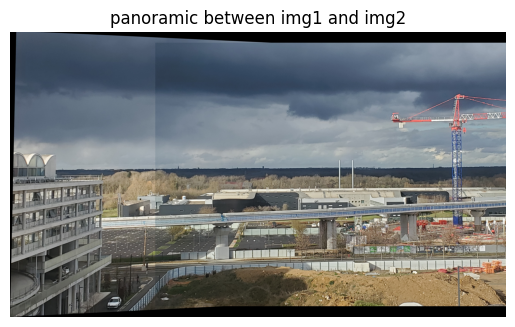

True

In [2]:
outputName='panorama.tif'


img1c = cv.imread('palaiseau-B1sub.tif',1)
img2c = cv.imread('palaiseau-B2sub.tif',1)
#
#img2c = cv.imread('panorama.tif',1)
#img1c = cv.imread('palaiseau-B3sub.tif', 1)

img1 = cv.cvtColor(img1c, cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(img2c, cv.COLOR_BGR2GRAY)

img1c = cv.cvtColor(img1c, cv.COLOR_BGR2RGB)
img2c = cv.cvtColor(img2c, cv.COLOR_BGR2RGB)

# Initiate ORB detector, that it will be our detector object.
orb = cv.SIFT_create()


# find the keypoints and compute the descriptors with ORB for images
kpts1, des1 = orb.detectAndCompute(img1, None)
kpts2, des2 = orb.detectAndCompute(img2, None)


# Create a BFMatcher object.
bf = cv.BFMatcher_create()

# match descriptor
matches1to2 = bf.knnMatch(des1, des2, k=2)


# draw matches
good1to2 = []
for m, n in matches1to2:
    if m.distance < 0.6 * n.distance:
        good1to2.append(m)

drawimg=draw_matches(img1, kpts1, img2, kpts2, good1to2)


# find  affine transformation and panoramic view between 1 to 2
matrix1to2 = find_homography(kpts1, kpts2, good1to2)
img1to2 = warpImages(img2c, img1c, matrix1to2)

figure()

imshow(drawimg)
show()


figure()

subplot(1, 2, 1)
imshow(img1c)
axis('off')
title('1')

subplot(1, 2, 2)
imshow(img2c)
axis('off')
title('2')

show()

figure()

title1 = "panoramic between img1 and img2"

subplot(1, 1, 1)
imshow(img1to2)
axis('off')
title(title1)

show()

img1to2 = cv.cvtColor(img1to2, cv.COLOR_BGR2RGB)
cv.imwrite(outputName,img1to2)

Changing distance threshold

0.2
[[ 1.00121383e+00  2.27157734e-02 -7.36547692e+02]
 [-2.27157734e-02  1.00121383e+00  1.96865434e+01]]
[[ 1.14812401e+00 -2.27828614e-02 -8.16376520e+02]
 [ 5.97011584e-02  1.08478818e+00 -7.95502631e+01]
 [ 8.06258261e-05 -1.05322056e-05  1.00000000e+00]]
-865 -80 2016 1586


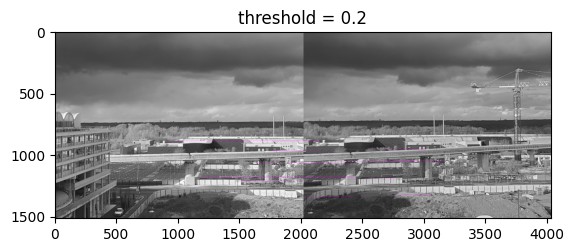

0.4
[[ 9.61842862e-01  2.85801890e-02 -6.85086016e+02]
 [-2.85801890e-02  9.61842862e-01  7.19291062e+01]]
[[ 1.15826073e+00 -9.71398280e-03 -8.37530545e+02]
 [ 5.72467228e-02  1.10773608e+00 -8.85703186e+01]
 [ 7.88143954e-05  2.04663681e-06  1.00000000e+00]]
-850 -89 2016 1581


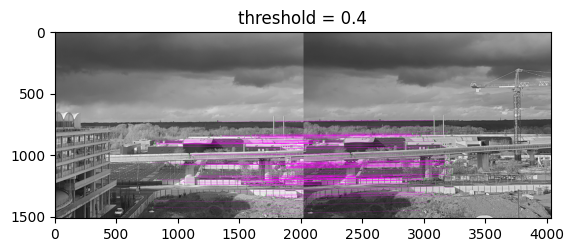

0.6
[[ 9.63091486e-01  2.77230199e-02 -6.86159131e+02]
 [-2.77230199e-02  9.63091486e-01  6.90176067e+01]]
[[ 1.15464782e+00 -1.30983988e-02 -8.31059947e+02]
 [ 5.75871665e-02  1.09998765e+00 -8.46865727e+01]
 [ 7.91412660e-05 -1.69150607e-06  1.00000000e+00]]
-853 -85 2016 1583


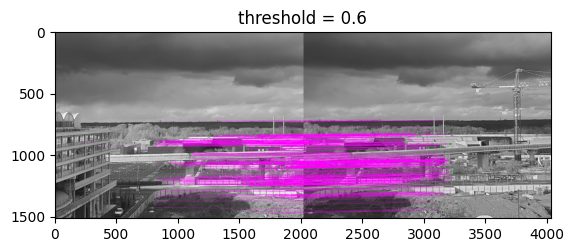

0.8
[[ 9.65923840e-01  2.70782319e-02 -6.90351174e+02]
 [-2.70782319e-02  9.65923840e-01  6.45803205e+01]]
[[ 1.12441869e+00 -1.80710540e-02 -7.96422942e+02]
 [ 4.94676332e-02  1.07514747e+00 -6.75024373e+01]
 [ 6.94505702e-05 -6.88889222e-06  1.00000000e+00]]
-832 -68 2016 1575


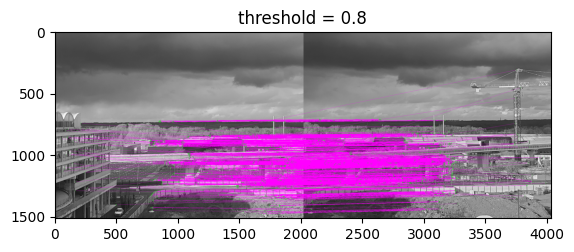

1
[[ 9.42833491e-01 -6.05968470e-03 -6.10446756e+02]
 [ 6.05968470e-03  9.42833491e-01  2.63187746e+01]]
[[ 1.13567400e+00 -1.80593922e-02 -8.07849361e+02]
 [ 5.27562368e-02  1.08223845e+00 -7.25710380e+01]
 [ 7.37410835e-05 -6.48600405e-06  1.00000000e+00]]
-843 -73 2016 1579


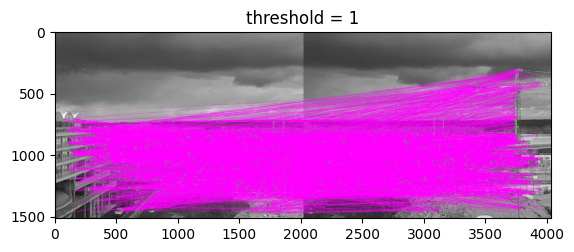

In [13]:
outputName='panorama.tif'

img1c = cv.imread('palaiseau-B1sub.tif',1)
img2c = cv.imread('palaiseau-B2sub.tif',1)
#
#img2c = cv.imread('panorama.tif',1)
#img1c = cv.imread('palaiseau-B3sub.tif', 1)

img1 = cv.cvtColor(img1c, cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(img2c, cv.COLOR_BGR2GRAY)

img1c = cv.cvtColor(img1c, cv.COLOR_BGR2RGB)
img2c = cv.cvtColor(img2c, cv.COLOR_BGR2RGB)

for i in [0.2, 0.4, 0.6, 0.8, 1]:

    # Initiate ORB detector, that it will be our detector object.
    orb = cv.ORB_create(10000)


    # find the keypoints and compute the descriptors with ORB for images
    kpts1, des1 = orb.detectAndCompute(img1, None)
    kpts2, des2 = orb.detectAndCompute(img2, None)


    # Create a BFMatcher object.
    bf = cv.BFMatcher_create(cv.NORM_HAMMING)

    # match descriptor
    matches1to2 = bf.knnMatch(des1, des2, k=2)


    # draw matches
    good1to2 = []
    print (i)
    for m, n in matches1to2:
        if m.distance < i * n.distance:
            good1to2.append(m)

    drawimg=draw_matches(img1, kpts1, img2, kpts2, good1to2)


    # find  affine transformation and panoramic view between 1 to 2
    matrix1to2 = find_homography(kpts1, kpts2, good1to2)
    img1to2 = warpImages(img2c, img1c, matrix1to2)

    figure()

    imshow(drawimg)
    title('threshold = ' + str(i))
    show()




    img1to2 = cv.cvtColor(img1to2, cv.COLOR_BGR2RGB)
    cv.imwrite(outputName,img1to2)

- We can see that the geometrical transformation applied is "cv.estimateAffinePartial2D". This function computes an optimal limited affine transformation with 4 degrees of freedom between two 2D point sets. Therefore, the pre-implemented geometrical transformation is just an affine transformation. We can see that the output image is relatively good, so the transformation was appropriate for this problem.
- It is possible to observe that, when we change the feature transform, for example, to SIFT, it outputs a better result in relation to ORB, since the black edges become smaller. That is, the output image is better stitched in relation to the original case.
- When we modify the distance threshold, we can see that it selects more keypoints as we increase the threshold. This is expeceted, since the threshold is the maximum distance between two keypoints for them to be considered as corresponding points. 

# Question 2

In [29]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Feb  6 21:06:13 2022

@author: roux
"""


import cv2 
import numpy as np 
import matplotlib.pyplot as plt

img = cv2.imread('f7.tif') 
imrvb=img.copy()


gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)     

kernel = np.ones((9,9),np.uint8)
#gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

gray = cv2.GaussianBlur(gray,(9,9),0)

#gray = cv2.medianBlur(gray, ksize=13)

gray_gauss = gray.copy()
  
edges = cv2.Canny(gray,20,180,apertureSize =3) 
  
edges_1_gauss = edges.copy()

    
lines = cv2.HoughLines(edges,1,2*np.pi/180,100) 

nbrlines = lines.shape[0]

#print('nombre de lignes : ', lines)

#print('nombre de lignes : ', nbrlines)


for line1 in range(nbrlines):  
    r1,theta1 = lines[line1][0]
    #print(r1,theta1)

nbrintersects=0

fichier = open("data.txt", "w")

for line1 in range(nbrlines):  
    r1,theta1 = lines[line1][0]
    
    a1 = np.cos(theta1) 
    b1 = np.sin(theta1)
    c1 = -r1
    
    x1 = int(a1*r1 + 4000*(-b1)) 
    y1 = int(b1*r1 + 4000*(a1)) 
    x2 = int(a1*r1 - 4000*(-b1)) 
    y2 = int(b1*r1 - 4000*(a1)) 
          
    (a,b,c)=125+125*np.random.rand(3, 1)
    a=int(0)
    b=int(255)
    c=int(0)
    cv2.line(imrvb,(x1,y1), (x2,y2), (a,b,c),7) 
    cv2.line(edges,(x1,y1), (x2,y2), (a,b,c),7) 
    
    x1=int(a1+5)
    y1=int(b1+5)
    x2=int(a1-5)
    y2=int(b1-5)
    
    a=255
    b=0
    c=0
    
    cv2.line(imrvb,(x1,y1), (x2,y2), (a,b,c),5) 
    cv2.line(edges,(x1,y1), (x2,y2), (a,b,c),5) 


    for line2 in range(line1):
        
        r2,theta2 = lines[line2][0]

        a2 = np.cos(theta2) 
        b2 = np.sin(theta2)
        c2 = -r2
    
        
        X =   b1 * c2 - c1 * b2
        Y =   c1 * a2 - a1 * c2
        Z =   a1 * b2 - b1 * a2
        

        if Z != 0:
            
            X=X/Z
            Y=Y/Z   
            
            if 0 < X < img.shape[1]:
                if 0 < Y < img.shape[0]:
                                
                    nbrintersects += 1
                    
                    #print(int(X),int(Y))
                    
                    fichier.write(str ( int ( X ) ) )
                    fichier.write (" ")
                    fichier.write(str ( int ( Y ) ) ) 
                    fichier.write("\n")
                    
                    x1=int(X+5)
                    y1=int(Y+5)
                    x2=int(X-5)
                    y2=int(Y-5)
                
                    a=255
                    b=0
                    c=0
                
                    cv2.line(imrvb,(x1,y1), (x2,y2), (a,b,c),5) 
                    cv2.line(edges,(x1,y1), (x2,y2), (a,b,c),5) 
        
                    x1=int(X-5)
                    y1=int(Y+5)
                    x2=int(X+5)
                    y2=int(Y-5)
        
                    cv2.line(imrvb,(x1,y1), (x2,y2), (a,b,c),5) 
                    cv2.line(edges,(x1,y1), (x2,y2), (a,b,c),5) 

fichier.close()


print('nbr intersects',nbrintersects)
edges_2_gauss = edges.copy()
imrvb_gauss = imrvb.copy()


cv2.imwrite('linesDetected.jpg', img) 






nbr intersects 55


True

A =  [1, 2, 3]


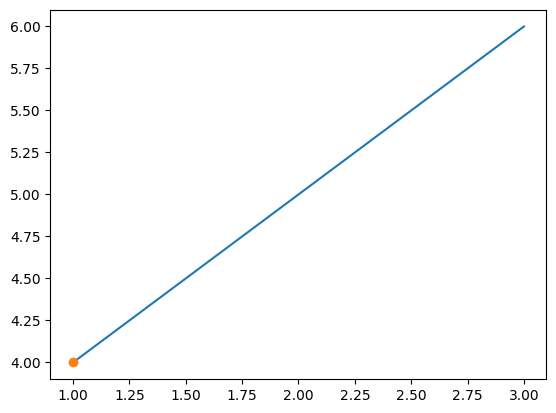

In [4]:
import matplotlib.pyplot as plt
a = [1,2,3]
b = [4,5,6]
print ('A = ', a)
plt.plot(a,b)
#mark the minimum point
plt.plot(a[0],b[0],'o')
plt.show()

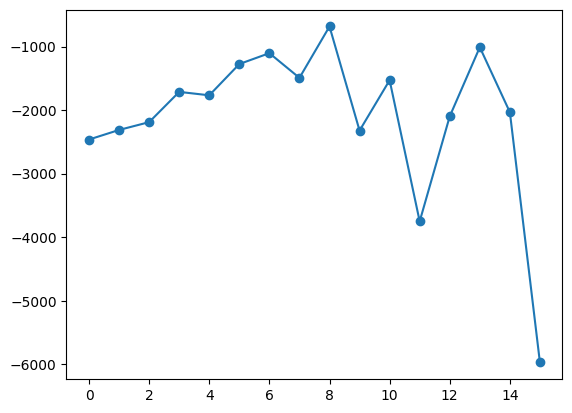

In [21]:
values = [ -684.55840105, -1011.27324981, -1104.50386538, -1275.66834663,
 -1493.1501472,  -1530.04884764, -1713.78072526, -1767.7980839,
 -2033.40219727, -2098.69014853, -2190.03861463, -2312.87950651,
 -2322.85168501, -2463.74163494, -3751.52810868, -5972.18740024]
coefficients = [8, 13, 6, 5, 7, 10, 3, 4, 14, 12, 2, 1, 9, 0, 11, 15]
import numpy as np
#sort values in relation to coefficients
values2 = [x for _,x in sorted(zip(coefficients,values))]
plt.scatter(coefficients,values)
plt.plot(np.sort(coefficients), values2)
 

In [12]:
values2

[-2463.74163494,
 -2312.87950651,
 -2190.03861463,
 -1713.78072526,
 -1767.7980839,
 -1275.66834663,
 -1104.50386538,
 -1493.1501472,
 -684.55840105,
 -2322.85168501,
 -1530.04884764,
 -3751.52810868,
 -2098.69014853,
 -1011.27324981,
 -2033.40219727,
 -5972.18740024]

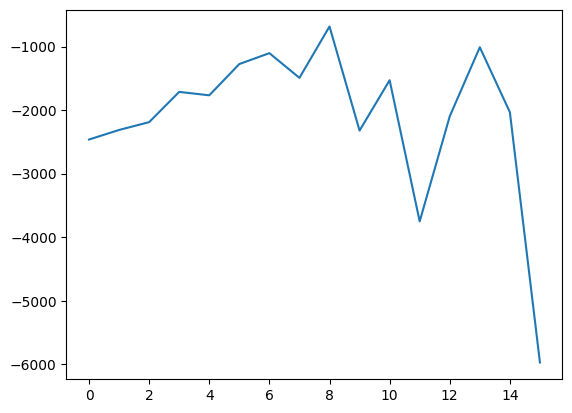

In [13]:
plt.plot(values2)

In [8]:
values

[-684.55840105,
 -1011.27324981,
 -1104.50386538,
 -1275.66834663,
 -1493.1501472,
 -1530.04884764,
 -1713.78072526,
 -1767.7980839,
 -2033.40219727,
 -2098.69014853,
 -2190.03861463,
 -2312.87950651,
 -2322.85168501,
 -2463.74163494,
 -3751.52810868,
 -5972.18740024]

In [30]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Feb  6 21:06:13 2022

@author: roux
"""


import cv2 
import numpy as np 
import matplotlib.pyplot as plt

img = cv2.imread('f7.tif') 
imrvb=img.copy()


gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)     

kernel = np.ones((9,9),np.uint8)
#gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

#gray = cv2.GaussianBlur(gray,(9,9),0)

gray = cv2.medianBlur(gray, ksize=13)

gray_m = gray.copy()
  
edges = cv2.Canny(gray,20,180,apertureSize =3) 
  
edges_1_m = edges.copy()

    
lines = cv2.HoughLines(edges,1,2*np.pi/180,100) 

nbrlines = lines.shape[0]

#print('nombre de lignes : ', lines)

#print('nombre de lignes : ', nbrlines)


for line1 in range(nbrlines):  
    r1,theta1 = lines[line1][0]
    #print(r1,theta1)

nbrintersects=0

fichier = open("data.txt", "w")

for line1 in range(nbrlines):  
    r1,theta1 = lines[line1][0]
    
    a1 = np.cos(theta1) 
    b1 = np.sin(theta1)
    c1 = -r1
    
    x1 = int(a1*r1 + 4000*(-b1)) 
    y1 = int(b1*r1 + 4000*(a1)) 
    x2 = int(a1*r1 - 4000*(-b1)) 
    y2 = int(b1*r1 - 4000*(a1)) 
          
    (a,b,c)=125+125*np.random.rand(3, 1)
    a=int(0)
    b=int(255)
    c=int(0)
    cv2.line(imrvb,(x1,y1), (x2,y2), (a,b,c),7) 
    cv2.line(edges,(x1,y1), (x2,y2), (a,b,c),7) 
    
    x1=int(a1+5)
    y1=int(b1+5)
    x2=int(a1-5)
    y2=int(b1-5)
    
    a=255
    b=0
    c=0
    
    cv2.line(imrvb,(x1,y1), (x2,y2), (a,b,c),5) 
    cv2.line(edges,(x1,y1), (x2,y2), (a,b,c),5) 


    for line2 in range(line1):
        
        r2,theta2 = lines[line2][0]

        a2 = np.cos(theta2) 
        b2 = np.sin(theta2)
        c2 = -r2
    
        
        X =   b1 * c2 - c1 * b2
        Y =   c1 * a2 - a1 * c2
        Z =   a1 * b2 - b1 * a2
        

        if Z != 0:
            
            X=X/Z
            Y=Y/Z   
            
            if 0 < X < img.shape[1]:
                if 0 < Y < img.shape[0]:
                                
                    nbrintersects += 1
                    
                    #print(int(X),int(Y))
                    
                    fichier.write(str ( int ( X ) ) )
                    fichier.write (" ")
                    fichier.write(str ( int ( Y ) ) ) 
                    fichier.write("\n")
                    
                    x1=int(X+5)
                    y1=int(Y+5)
                    x2=int(X-5)
                    y2=int(Y-5)
                
                    a=255
                    b=0
                    c=0
                
                    cv2.line(imrvb,(x1,y1), (x2,y2), (a,b,c),5) 
                    cv2.line(edges,(x1,y1), (x2,y2), (a,b,c),5) 
        
                    x1=int(X-5)
                    y1=int(Y+5)
                    x2=int(X+5)
                    y2=int(Y-5)
        
                    cv2.line(imrvb,(x1,y1), (x2,y2), (a,b,c),5) 
                    cv2.line(edges,(x1,y1), (x2,y2), (a,b,c),5) 

fichier.close()


print('nbr intersects',nbrintersects)
edges_2_m = edges.copy()
imrvb_m = imrvb.copy()


cv2.imwrite('linesDetected.jpg', img) 






nbr intersects 71


True

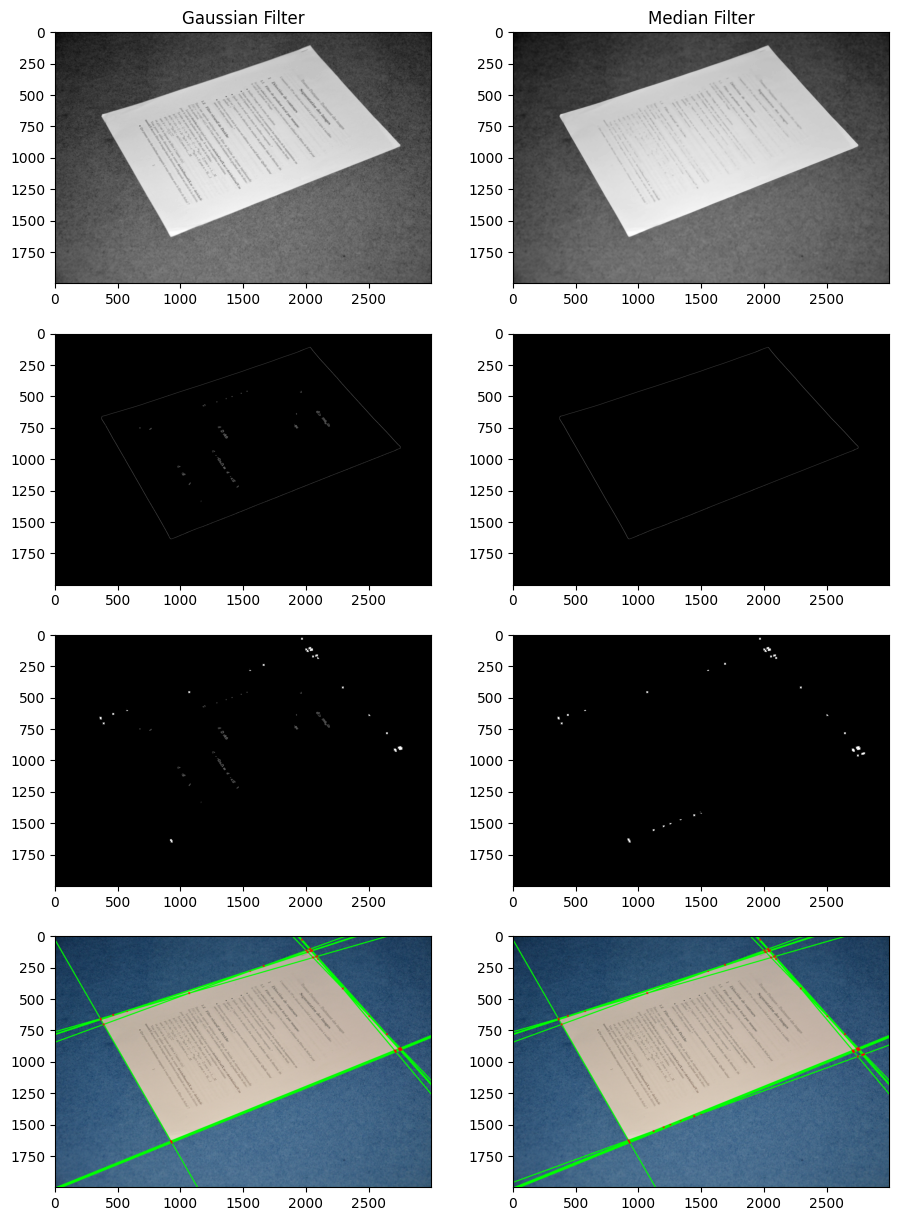

In [48]:
ax,fig = plt.subplots(4, 2, figsize=(15, 15))
fig[0,0].imshow(gray_gauss, cmap='gray')
fig[0,0].set_title('Gaussian Filter')
fig[0,1].imshow(gray_m, cmap='gray')
fig[0,1].set_title('Median Filter')
fig[1,0].imshow(edges_1_gauss, cmap='gray')
fig[1,1].imshow(edges_1_m, cmap='gray')
fig[2,0].imshow(edges_2_gauss, cmap='gray')
fig[2,1].imshow(edges_2_m, cmap='gray')
fig[3,0].imshow(imrvb_gauss, cmap='gray')
fig[3,1].imshow(imrvb_m, cmap='gray')

#make the images closer
plt.subplots_adjust(wspace=-0.35)




* 
* 
* 

# Question 3

pts1 [[0, 0], [1050, 0], [1050, 1485], [0, 1485], [36.093924498593225, 34.048200456688164]]
pts2 [[2030, 110], [2750, 904], [920, 1638], [363, 663], [-156.4310108778535, 245.5820162143229]]
points feuille
(0.0, 0.0)
(1050.0, 0.0)
(1050.0, 1485.0)
(0.0, 1485.0)
(36.09392547607422, 34.04819869995117)
points image
(2030.0, 110.0)
(2750.0, 904.0)
(920.0, 1638.0)
(363.0, 663.0)
(-156.43101501464844, 245.58201599121094)
matchess
0.0 0.0 2030.0 110.0
1050.0 0.0 2750.0 904.0
1050.0 1485.0 920.0 1638.0
0.0 1485.0 363.0 663.0
36.09392547607422 34.04819869995117 -156.43101501464844 245.58201599121094
points


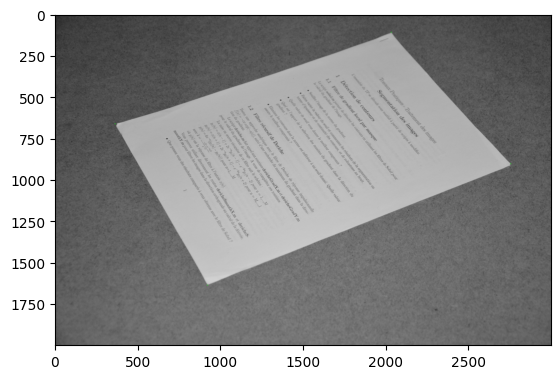

[[-1.54829495e-02  1.65326086e-02  2.96118006e+01]
 [-1.65326086e-02 -1.54829495e-02  3.52643199e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 3.85189924e-01  1.16114214e+00 -9.09661180e+02]
 [-7.63172919e-01  6.92045971e-01  1.47311597e+03]
 [-6.13465327e-06  1.75934908e-04  1.00000000e+00]]
[[1]
 [1]
 [1]
 [1]
 [0]]


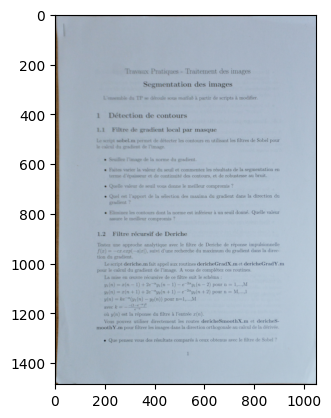

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  2 13:49:38 2022

@author:
"""


import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow, show, subplot, title, axis, figure, plot


# draw matches
def draw_matches(img2, kpt2, matches,rayon):

    h2, w2 = img2.shape[:2]

    # Create a blank image with the size of the first image + second image
    new_img = np.zeros((h2, w2, 3), dtype='uint8')
#    new_img[:h2, :w2, :] = np.dstack([img2, img2, img2])
    new_img[:h2, :w2, :] = np.dstack([img2])

    # extract the match keypoints
    
    for m in matches:
        (x2, y2) = kpt2[m.trainIdx].pt

        # Draw circles on the keypoints
        cv.circle(new_img, (int(x2), int(y2)), rayon, (255, 255, 255), 1)

    return new_img


def warpImages(kp, img, M):
    # get the corner coordinates of the "query" and "train" image
    h=kp[2].pt[1]
    w=kp[2].pt[0]
            
    new_img = cv.warpPerspective(img, M,(np.int32(w),np.int32(h)))

    return new_img


def find_homography(kpt1, kpt2, matches):
    # Find an Homography matrix between two pictures
    # Transforming keypoints to list of points
   
    dst_pts = np.float32([kpt1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    src_pts = np.float32([kpt2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
 
    # Compute a rigid transformation (only scale + rotation + translation) /affine transformation
    affine_matrix, rigid_mask = cv.estimateAffinePartial2D(src_pts, dst_pts)    
    affine_row = [0, 0, 1]
    affine_matrix = np.vstack((affine_matrix, affine_row))
    
    M=affine_matrix
    print(M)

    # Compute an homography
        
    M, mask = cv.findHomography(src_pts, dst_pts,cv.RANSAC,3)

    print(M)
    print(mask)
    
    return M
    #return affine_matrix


# Read images

img1c = cv.imread('f7.jpg', 1)


img1 = cv.cvtColor(img1c, cv.COLOR_BGR2GRAY)

img1c = cv.cvtColor(img1c, cv.COLOR_BGR2RGB)


Noutliers=1

# Données pour l'image redressée

resol=5
x1=0
y1=0
sizeH=210
sizeV=297
x2=resol*sizeH
y2=resol*sizeV

pts1=[]
pts1.append([x1,y1])
pts1.append([x2,y1])
pts1.append([x2,y2])
pts1.append([x1,y2])




demil=(x1+x2)/4
demih=(y1+y2)/4

for i in range(Noutliers):
    pts1.append([demil+demil*np.random.randn(),demih+demih*np.random.randn()])


print('pts1',pts1)




# données pour f6.jpg

x1=248
y1=949
x2=1450
y2=924
x3=1541
y3=2592
x4=225
y4=2621


# données pour f7.jpg

x1=2030
y1=110
x2=2750
y2=904
x3=920
y3=1638
x4=363
y4=663


demil=(x1+x2+x3+x4)/8
demih=(y1+y2+y3+y4)/8

pts2=[]
pts2.append([x1,y1])
pts2.append([x2,y2])
pts2.append([x3,y3])
pts2.append([x4,y4])

for i in range(Noutliers):
    pts2.append([demil+demil*np.random.randn(),demih+demih*np.random.randn()])

print('pts2', pts2)


kp1 = [cv.KeyPoint(x[0], x[1], 1) for x in pts1]
kp2 = [cv.KeyPoint(x[0], x[1], 1) for x in pts2]

print('points feuille')
for i in range (len(pts1)):
    print(kp1[i].pt)

print('points image')
for i in range (len(pts2)):
    print(kp2[i].pt)


goodMatches=[]
for i in range(len(pts1)):
    m=cv.DMatch(i,i,0)
    goodMatches.append(m)

print('matchess')
for m in goodMatches:
    (x1, y1) = kp1[m.queryIdx].pt
    (x2, y2) = kp2[m.trainIdx].pt
    print ( x1,y1,x2,y2)
print('points')

figure()

kp_img = cv.drawKeypoints(img1, kp2, None, color=(0, 255, 0))


imshow(kp_img)
show()


#
## find  affine transformation and panoramic view between 1 to 2
matrix1to2 = find_homography(kp1, kp2,goodMatches)
img1to2 = warpImages(kp1,img1c, matrix1to2)
#

figure()

imshow(img1to2)
show()












